# HappyDBで文章分類してみる（英語, BoW/TF-IDF）

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## 1. HappyDBをダウンロード

GitHubより、必要なファイル（"cleaned_hm.csv"）だけをダウンロードする

（参考）HappyDBについて
- 論文
  - ["HappyDB: A Corpus of 100,000 Crowdsourced Happy Moments" (Asai, et al., 2018)](https://arxiv.org/pdf/1801.07746.pdf)
- データ
  - [GitHub - megagonlabs/HappyDB](https://github.com/megagonlabs/HappyDB)
  - [Kaggle - HappyDB](https://www.kaggle.com/datasets/ritresearch/happydb)

In [2]:
! wget https://github.com/megagonlabs/HappyDB/raw/master/happydb/data/cleaned_hm.csv

--2022-05-29 13:10:14--  https://github.com/megagonlabs/HappyDB/raw/master/happydb/data/cleaned_hm.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/megagonlabs/HappyDB/master/happydb/data/cleaned_hm.csv [following]
--2022-05-29 13:10:14--  https://raw.githubusercontent.com/megagonlabs/HappyDB/master/happydb/data/cleaned_hm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22501526 (21M) [text/plain]
Saving to: ‘cleaned_hm.csv’

cleaned_hm.csv      100%[===================>]  21.46M  --.-KB/s    in 0.09s   

2022-05-29 13:10:14 (252 MB/s) - ‘cleaned_hm.csv’ saved [22501526/22501526]



## 2. HappyDBを読み込む

### データ概要

カラムの意味（主要なもの）
- hmid : 幸せな瞬間（HappyMoment）のID
- wid : データ収集協力者のID
- reflection_period : 時間の範囲（24h/3m)
- cleaned_hm : 記述文（誤字脱字修正版）
- ground_truth_category : カテゴリラベル

カテゴリ種別
- __Achievement__
    - With extra effort to achieve a better than expected result
    - Finish work. Complete marathon.
- __Affection__
    - Meaningful interaction with family, loved ones and pets
    - Hug. Cuddle. Kiss.
- __Bonding__
    - Meaningful interaction with friends and colleagues
    - Have meals w coworker. Meet with friends.
- __Enjoy__
    - the moment Being aware or reflecting on present environment
    - Have a good time. Mesmerize.
- __Exercise__
    - With intent to exercise or workout
    - Run. Bike. Do yoga. Lift weights.
- __Leisure__
    - An activity done regularly in one’s free time for pleasure
    - Play games. Watch movie. Bake cookies.
- __Nature__
    - In the open air, in nature
    - Garden. Beach. Sunset. Weather

### データの確認

In [3]:
df_hm = pd.read_csv('cleaned_hm.csv')
df_hm.head(3)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise


In [4]:
# ラベル無しデータは除外する
df_hm_target = df_hm.dropna(subset=['ground_truth_category'])

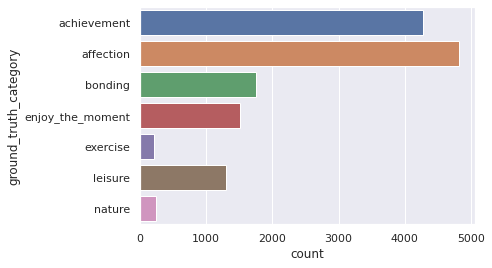

In [5]:
# ラベルの分布を見てみる
LABELS_ALL = sorted(df_hm_target.ground_truth_category.unique())
sns.countplot(y='ground_truth_category', data=df_hm, order=LABELS_ALL)

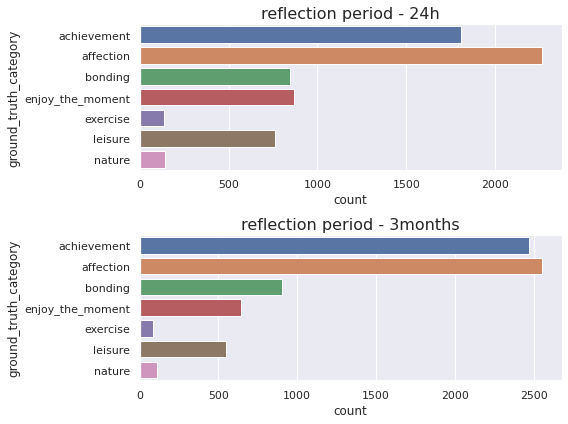

In [6]:
plt.figure(figsize=(8, 6))
plt.subplot(2,1,1)
sns.countplot(y='ground_truth_category', data=df_hm[df_hm.reflection_period=='24h'], order=LABELS_ALL)
plt.title('reflection period - 24h', fontsize=16)

plt.subplot(2,1,2)
sns.countplot(y='ground_truth_category', data=df_hm[df_hm.reflection_period=='3m'], order=LABELS_ALL)
plt.title('reflection period - 3months', fontsize=16)

plt.tight_layout()

## 3. BoWで文章分類してみる

In [7]:
docs = df_hm_target['cleaned_hm'].tolist()

labels = df_hm_target['ground_truth_category'].tolist()
label_ids = np.array([LABELS_ALL.index(label) for label in labels])

print('label : {} ( id = {} )\ntext : {}'.format(labels[0], label_ids[0], docs[0]))

label : bonding ( id = 2 )
text : We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.


In [8]:
# BoWを用いた文章分類
docs_train, docs_test, y_train, y_test = train_test_split(docs, label_ids)

# BoW (CountVectorizer)
bow_vectorizer = CountVectorizer(stop_words='english')
bow_vectorizer.fit(docs)
# BoWでベクトル化
x_train = bow_vectorizer.transform(docs_train).toarray()
x_test = bow_vectorizer.transform(docs_test).toarray()

# ロジスティック回帰
# max_iterを指定しない（デフォルト値100）場合、収束しないとWarningが発生
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train, y_train)
acc = logreg.score(x_test, y_test)
print(acc)

0.8278595696489242


In [9]:
# 出現頻度に関するパラメータ（max_df, min_df）の影響
# なお、df は Document Frequency の略
for min_df in (0.0, 0.0001, 0.001, 0.005, 0.01):
    for max_df in (0.2, 0.3, 0.5, 1.0):
        
        bow_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
        bow_vectorizer.fit(docs)
        n_vocab = len(bow_vectorizer.get_feature_names_out())
        x_train = bow_vectorizer.transform(docs_train).toarray()
        x_test = bow_vectorizer.transform(docs_test).toarray()

        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(x_train, y_train)
        acc = logreg.score(x_test, y_test)

        print('min_df: {}, max_df: {}, # vocabularies: {} --- Acc. {}'.format(min_df, max_df, n_vocab, acc))

min_df: 0.0, max_df: 0.2, # vocabularies: 9539 --- Acc. 0.8278595696489242
min_df: 0.0, max_df: 0.3, # vocabularies: 9539 --- Acc. 0.8278595696489242
min_df: 0.0, max_df: 0.5, # vocabularies: 9539 --- Acc. 0.8278595696489242
min_df: 0.0, max_df: 1.0, # vocabularies: 9539 --- Acc. 0.8278595696489242
min_df: 0.0001, max_df: 0.2, # vocabularies: 5135 --- Acc. 0.8281426953567383
min_df: 0.0001, max_df: 0.3, # vocabularies: 5135 --- Acc. 0.8281426953567383
min_df: 0.0001, max_df: 0.5, # vocabularies: 5135 --- Acc. 0.8281426953567383
min_df: 0.0001, max_df: 1.0, # vocabularies: 5135 --- Acc. 0.8281426953567383
min_df: 0.001, max_df: 0.2, # vocabularies: 1112 --- Acc. 0.8207814269535674
min_df: 0.001, max_df: 0.3, # vocabularies: 1112 --- Acc. 0.8207814269535674
min_df: 0.001, max_df: 0.5, # vocabularies: 1112 --- Acc. 0.8207814269535674
min_df: 0.001, max_df: 1.0, # vocabularies: 1112 --- Acc. 0.8207814269535674
min_df: 0.005, max_df: 0.2, # vocabularies: 261 --- Acc. 0.7607587768969423
min_

In [10]:
# 論文(Table.10)との比較
# 5分割の効果検証で、クラス毎のPrecision, Recall, F1-scoreを求める

# BoW (CountVectorizer)
bow_vectorizer = CountVectorizer(min_df=0.0001, stop_words='english')
bow_vectorizer.fit(docs)
x_data = bow_vectorizer.transform(docs).toarray()

# ロジスティック回帰
logreg = LogisticRegression(max_iter=1000)

# 層化k分割交差検証
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

scores_all = []
for train_index, test_index in skf.split(x_data, label_ids):
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_true = label_ids[train_index], label_ids[test_index]

    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)

    # クラス別のPrecision, Recall, F1-scoreを計算
    scores = []
    scores.append(precision_score(y_true=y_true, y_pred=y_pred, average=None))
    scores.append(recall_score(y_true=y_true, y_pred=y_pred, average=None))
    scores.append(f1_score(y_true=y_true, y_pred=y_pred, average=None))
    scores_all.append(scores)

In [11]:
# 各スコアの平均値を算出
scores_mean = np.stack(scores_all).mean(axis=0)
df_scores_mean = pd.DataFrame(scores_mean.T, index=LABELS_ALL, columns=['precision', 'recall', 'f1'])
df_scores_mean

,precision,recall,f1
achievement,0.791723,0.880492,0.833702
affection,0.921157,0.926819,0.923941
bonding,0.928683,0.862286,0.894145
enjoy_the_moment,0.595908,0.540288,0.566441
exercise,0.857772,0.562156,0.677984
leisure,0.743091,0.694493,0.717890
nature,0.757363,0.503608,0.600125


In [12]:
# 参考）交差検証のシンプル版（クラス毎の値は出せなさそう）
# cf. https://www.haya-programming.com/entry/2018/03/31/184557

# BoW (CountVectorizer)
bow_vectorizer = CountVectorizer(min_df=0.001, stop_words='english')
bow_vectorizer.fit(docs)
x_data = bow_vectorizer.transform(docs).toarray()

# ロジスティック回帰
logreg = LogisticRegression(max_iter=1000)

# 層化k分割交差検証
skf = StratifiedKFold(shuffle=True, random_state=0)
scoring = {"p": "precision_macro",
           "r": "recall_macro",
           "f": "f1_macro"}
scores = cross_validate(logreg, x_data, label_ids, cv=skf, scoring=scoring)
print(scores)

{'fit_time': array([11.35091925, 12.24587488, 12.21126437, 12.09359527, 11.67816162]), 'score_time': array([0.0304265 , 0.02476597, 0.02453136, 0.02429032, 0.02438259]), 'test_p': array([0.81379355, 0.76045158, 0.79134274, 0.80636035, 0.80645642]), 'test_r': array([0.68504959, 0.69905654, 0.7100413 , 0.71130122, 0.68747527]), 'test_f': array([0.72832554, 0.72503363, 0.74372893, 0.74642652, 0.73019124])}


## 4. TF-IDFで文章分類してみる

In [13]:
# TF-IDFを用いた文章分類
# CountVectorizerをTfidfVectorizerに変更するだけ

# 論文(Table.10)との比較
# 5分割の効果検証で、クラス毎のPrecision, Recall, F1-scoreを求める

# TF-IDF (TfidfVectorizer)
tfidf_vectorizer = TfidfVectorizer(min_df=0.0001, stop_words='english')
tfidf_vectorizer.fit(docs)
x_data = tfidf_vectorizer.transform(docs).toarray()

# ロジスティック回帰
logreg = LogisticRegression(max_iter=1000)

# 層化k分割交差検証
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

scores_all = []
for train_index, test_index in skf.split(x_data, label_ids):
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_true = label_ids[train_index], label_ids[test_index]

    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)

    # クラス別のPrecision, Recall, F1-scoreを計算
    scores = []
    scores.append(precision_score(y_true=y_true, y_pred=y_pred, average=None))
    scores.append(recall_score(y_true=y_true, y_pred=y_pred, average=None))
    scores.append(f1_score(y_true=y_true, y_pred=y_pred, average=None))
    scores_all.append(scores)

In [14]:
# 各スコアの平均値を算出
scores_mean = np.stack(scores_all).mean(axis=0)
df_scores_mean = pd.DataFrame(scores_mean.T, index=LABELS_ALL, columns=['precision', 'recall', 'f1'])
df_scores_mean

,precision,recall,f1
achievement,0.747931,0.912298,0.821957
affection,0.891678,0.928482,0.909664
bonding,0.941063,0.827429,0.880336
enjoy_the_moment,0.628171,0.476220,0.541319
exercise,0.951818,0.409937,0.566987
leisure,0.796006,0.624816,0.700044
nature,0.838128,0.317255,0.455553


## 参考文献
- [Qiita - scikit-learn を用いた交差検証（Cross-validation）とハイパーパラメータのチューニング（grid search）](https://qiita.com/tomov3/items/039d4271ed30490edf7b)
- [静かなる名辞 - cross_val_scoreはもうやめようね。一発で交差検証するにはcross_validateを使う](https://www.haya-programming.com/entry/2018/03/31/184557)
- [静かなる名辞 - 【python】sklearnのCountVectorizerの使い方](https://www.haya-programming.com/entry/2018/02/25/044525)